# Reproducing CLT with GNN

In [ ]:
import torch
from torch.utils.data import Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric.nn as pyg_nn
from torch_geometric.nn import GCNConv
from torch_geometric.utils import add_self_loops
import torch_geometric.utils as pyg_utils
from torch_geometric.utils import to_networkx
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F
# from torch.utils.data import DataLoader
from torch_geometric.nn import SAGEConv
from openpyxl import load_workbook
import random

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


# Set seed for reproducibility
SEED = 43
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data

Create many full graphs, each of 2 nodes, that get batched up

In [29]:
# Sample pairs of points from a 1D uniform distribution
def get_data_uniform(number):
    x = np.random.uniform(low=-0.5, high=0.5, size=(number, 2))
    decimated_x = np.sum(x, axis=1) / np.sqrt(2) # array shape (n, 2) -> (n, 1)
    return x, decimated_x

def get_data_gaussian(number): # centred unit gaussian
    x = np.random.normal(loc=0, scale=1.0, size=(number, 2)) # loc is mean, scale is stdev (not variance)
    decimated_x = np.sum(x, axis=1) / np.sqrt(2) # array shape (n, 2) -> (n, 1)
    return x, decimated_x

def get_data_gaussian_shifted(number): # unit gaussian, mean shifted to 1/sqrt(2)
    x = np.random.normal(loc=1/(np.sqrt(2)), scale=1.0, size=(number, 2)) # loc is mean, scale is stdev (not variance)
    decimated_x = np.sum(x, axis=1) / np.sqrt(2) # array shape (n, 2) -> (n, 1)
    return x, decimated_x

def get_data_gaussian_varied(number, var):
    x = np.random.normal(loc=0, scale=np.sqrt(var), size=(number, 2)) # loc is mean, scale is stdev (not variance)
    decimated_x = np.sum(x, axis=1) / np.sqrt(2) # array shape (n, 2) -> (n, 1)
    return x, decimated_x

class GraphPairDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, idx):
        xi1 = self.inputs[idx, 0]
        xi2 = self.inputs[idx, 1]
        target = self.targets[idx]

        # Node features: shape [2, 1]
        x = torch.tensor([[xi1], [xi2]], dtype=torch.float32)

        # Directed edge: A (node 0) → B (node 1)
        edge_index = torch.tensor([[0], [1]], dtype=torch.long)

        y = torch.tensor([target], dtype=torch.float32)

        return Data(x=x, edge_index=edge_index, y=y)

n_train = int(1e5)
n_test = int(1e5)
var = 2

# Gaussian train set
x_train, y_train = get_data_gaussian(n_train)
train_dataset = GraphPairDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# # Varied Gaussian test set
# x_test, y_test = get_data_gaussian_varied(n_test, var)
# test_dataset = GraphPairDataset(x_test, y_test)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define Model

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

class sage_model(nn.Module):
    def __init__(self):
        super(sage_model, self).__init__()
        self.conv1 = SAGEConv(1, 2, bias=False, aggr='add')
        self.conv2 = SAGEConv(2, 1, bias=False, aggr='add')

        # self.conv1 = SAGEConv(1, 1, bias=False, aggr='add')

    def forward(self, data):
        # Try using no activation
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        
        # x = self.conv1(x, edge_index)

        # Extracting Node B's output only
        num_nodes_per_subgraph = 2
        updated_node_indices = torch.arange(1, x.size(0), num_nodes_per_subgraph).to(x.device)
        return x[updated_node_indices]


Using cpu device


# Training

In [31]:
def enforce_self_equals_neigh(model):
    for module in model.modules():
        if isinstance(module, SAGEConv):
            module.lin_r.weight.data = module.lin_l.weight.data.clone()

def train(dataloader, model, loss_fn, optimizer, 
          track_loss=False, track_params=False, eps=1e-4):
    
    size = len(dataloader.dataset)
    model.train()
    loss_steps = []
    loss_values = []
    param_steps = []
    param_changes = []
    step = 0

    if track_params:
        prev_params = {name: param.clone().detach() for name, param in model.named_parameters()}

    for batch_idx, data in enumerate(dataloader):
        data = data.to(device)
        target = data.y.to(device)  # shape: (batch_size, 1)

        # Forward pass
        pred = model(data)  # model returns only Node B outputs
        loss = loss_fn(pred.squeeze(), target.squeeze())

        # Soft symmetry regularization
        symm_penalty = 0.0
        for module in model.modules():
            if isinstance(module, SAGEConv):
                symm_penalty += torch.norm(module.lin_l.weight - module.lin_r.weight, p=2)

        loss += eps * symm_penalty

        lambda_reg = 5e-3  # Adjust as needed. 1e-2 works pretty well.
        reg_term = (torch.norm(model.conv2.lin_l.weight)**2 + 
                    torch.norm(model.conv2.lin_r.weight)**2)
        loss += lambda_reg * (1.0 - reg_term)**2



        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # enforce_self_equals_neigh(model)

        if track_loss:
            loss_steps.append(step)
            loss_values.append(loss.item())

        if track_params and step % 10 == 0 and step > 0:
            total_param_change = 0
            for name, param in model.named_parameters():
                param_diff = param.detach() - prev_params[name]
                total_param_change += torch.sum(param_diff ** 2).item()
                prev_params[name] = param.clone().detach()
            param_steps.append(step)
            param_changes.append(np.sqrt(total_param_change))

        if batch_idx % 500 == 0:
            loss_val = loss.item()
            current = (batch_idx + 1) * data.num_graphs
            print(f"Current batch: {current:>5d}/{size:>5d}\n  Loss of batch: {loss_val:>7f}")

        step += 1

    return loss_steps, loss_values, param_steps, param_changes



Current batch:    64/100000
  Loss of batch: 0.845818
Current batch: 32064/100000
  Loss of batch: 0.009856
Current batch: 64064/100000
  Loss of batch: 0.000847
Current batch: 96064/100000
  Loss of batch: 0.000714
Current batch:    64/100000
  Loss of batch: 0.000698
Current batch: 32064/100000
  Loss of batch: 0.000562
Current batch: 64064/100000
  Loss of batch: 0.000437
Current batch: 96064/100000
  Loss of batch: 0.000333
Current batch:    64/100000
  Loss of batch: 0.000321
Current batch: 32064/100000
  Loss of batch: 0.000245
Current batch: 64064/100000
  Loss of batch: 0.000192
Current batch: 96064/100000
  Loss of batch: 0.000159
Current batch:    64/100000
  Loss of batch: 0.000156
Current batch: 32064/100000
  Loss of batch: 0.000140
Current batch: 64064/100000
  Loss of batch: 0.000131
Current batch: 96064/100000
  Loss of batch: 0.000127
Current batch:    64/100000
  Loss of batch: 0.000127
Current batch: 32064/100000
  Loss of batch: 0.000124
Current batch: 64064/100000


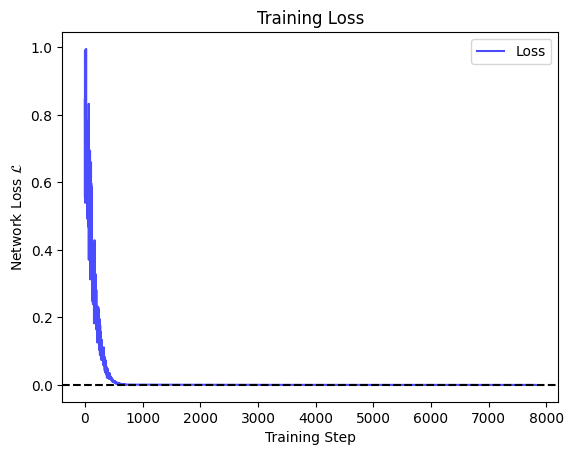

In [32]:
model = sage_model().to(device)  # same model as you posted earlier
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

tot_loss = []
tot_steps_loss = []
loss_step_count = 0

for epoch in range(5):
    loss_steps, loss_vals, _, _ = train(train_loader, model, loss_fn, optimizer,
                                        track_loss=True, track_params=False)
    loss_steps = [x + loss_step_count for x in loss_steps]
    loss_step_count += len(loss_steps)

    tot_loss.extend(loss_vals)
    tot_steps_loss.extend(loss_steps)

plt.plot(tot_steps_loss, tot_loss, label='Loss', color='blue', alpha=0.7)
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel("Training Step")
plt.ylabel("Network Loss $\mathcal{L}$")
plt.title("Training Loss")
plt.legend()
plt.show()


# Helper Functions

## Cumulant Extraction

In [33]:
def cumulant_extraction(data):
    """
    Compute the first four cumulants for a 1D array.
    Parameters:
        data: np.ndarray of shape (N,)
    Returns:
        A dictionary with cumulants k1 to k4
    """
    mean = np.mean(data)                          # κ1
    centered = data - mean

    var = np.mean(centered**2)                    # κ2
    third = np.mean(centered**3)                  # κ3
    fourth_raw = np.mean(centered**4)
    fourth = fourth_raw - 3 * var**2              # κ4

    return {
        'kappa1': mean,
        'kappa2': var,
        'kappa3': third,
        'kappa4': fourth
    }

def expected_cumulant_evolution(data):
    """Input: data is a dictionary of input cumulants
    This function scales each cumulant according to expected transform from the Jona-Lasinio paper."""
    
    scaled_cumulants = {}
    for key, value in data.items():
        # Extract the cumulant order (k) from the key string 'kappa{k}'
        k = int(key[-1])
        
        # Calculate the scaling factor
        scaling_factor = 2 ** (1 - k / 2)
        
        # Scale the cumulant value
        scaled_cumulants[key] = value * scaling_factor
    
    return scaled_cumulants

# import itertools
# def symmetrise_tensor(tensor):
#     """
#     Symmetrise a tensor over all its axes.
#     Args:
#         tensor (np.ndarray): A tensor of shape (d, d, ..., d)
#     Returns:
#         sym_tensor (np.ndarray): Symmetrised version of the input tensor.
#     """
#     order = tensor.ndim
#     perms = list(itertools.permutations(range(order)))
#     sym_tensor = sum(np.transpose(tensor, axes=perm) for perm in perms)
#     sym_tensor /= len(perms)
#     return sym_tensor

# def cumulant_extraction_multidim(data):
    """
    Compute the first four cumulants for a 2D array.
    Parameters:
        data: np.ndarray of shape (N, 2)
    Returns:
        A dictionary with cumulants k1 to k4
    """
    N, d = data.shape
    
    # Mean vector (κ1)
    mean = np.mean(data, axis=0)  # Shape: (2,)
    
    # Centered data
    centered = data - mean  # Shape: (N, 2)

    # κ2: Covariance matrix
    covariance = np.einsum('ni,nj->ij', centered, centered) / N  # Shape: (2, 2)
    
    # Third-order cumulant tensor (κ3)
    G3_raw = np.einsum('ni,nj,nk->ijk', centered, centered, centered) / N  # Shape: (2, 2, 2)
    G3 = symmetrise_tensor(G3_raw)
    
    # Fourth-order cumulant tensor (κ4)
    G4_raw = np.einsum('ni,nj,nk,nl->ijkl', centered, centered, centered, centered) / N  # Shape: (2, 2, 2, 2)
    
    # Full Gaussian correction for fourth cumulant
    cov = covariance
    term1 = np.einsum('ij,kl->ijkl', cov, cov)
    term2 = np.einsum('ik,jl->ijkl', cov, cov)
    term3 = np.einsum('il,jk->ijkl', cov, cov)
    kappa4_raw = G4_raw - (term1 + term2 + term3)
    kappa4 = symmetrise_tensor(kappa4_raw)  # Shape: (2, 2, 2, 2)
    
    # Package the results in a dictionary
    cumulants = {
        'kappa1': torch.tensor(mean, dtype=torch.float64),                     # Shape: (2,)
        'kappa2': torch.tensor(covariance, dtype=torch.float64),               # Shape: (2, 2)
        'kappa3': torch.tensor(G3, dtype=torch.float64),                       # Shape: (2, 2, 2)
        'kappa4': torch.tensor(kappa4, dtype=torch.float64)                        # Shape: (2, 2, 2, 2)
    }
    
    return cumulants

# Find input cumulants:
def find_input_cumulants(array):
    """array should be an (N, 2) array, NOT an actual pytorch dataset."""
    
    col1 = cumulant_extraction(array[:, 0])
    col2 = cumulant_extraction(array[:, 1])
    avg_cumulants = {k: 0.5 * (col1[k] + col2[k]) for k in col1}
    return col1, col2, avg_cumulants

# Compute output cumulants
def find_pred_output_cumulants(inputs, targets):
    """(N, 2) inputs, (N,) targets."""
    
    col1 = cumulant_extraction(inputs[:, 0])
    col2 = cumulant_extraction(inputs[:, 1])

    evolved1 = expected_cumulant_evolution(col1)
    evolved2 = expected_cumulant_evolution(col2)
    
    avg_evolved_cumulants = {k: 0.5 * (evolved1[k] + evolved2[k]) for k in evolved1}
    ground_truth_cumulants = cumulant_extraction(targets)

    return avg_evolved_cumulants, ground_truth_cumulants



## Propagation

Not using any biases

Thoughts:
- A only updates via self loops, B updates by both (directed edge). So need to find node A, B cumulant updates after each layer separately.

- A updates only with W_self, B updates with both (as in the below code)

In [34]:
def extract_weights(model):
    weights = []
    # biases = []

    for name, module in model.named_modules():
        if isinstance(module, SAGEConv):
            # Extract both self and neighbor weights
            W_self = module.lin_l.weight.detach().cpu().numpy()
            W_neigh = module.lin_r.weight.detach().cpu().numpy()
            weights.append({
                # "layer": name,
                "W_self": torch.tensor(W_self, dtype=torch.float64),
                "W_neigh": torch.tensor(W_neigh, dtype=torch.float64)
            })

            # # Bias, if it exists
            # if module.bias is not None:
            #     b = module.bias.detach().cpu().numpy()
            #     biases.append(torch.tensor(b, dtype=torch.float64))
            # else:
            #     biases.append(None)  # Maintain alignment with weights list

    return weights


def propagate_affine_layer1_nodeB(mean_list, cov_list, g3_list, g4_list, W_self, W_neigh):
    """
    Propagate cumulants through the first affine (SAGEConv) layer using list input.
    
    Inputs:
        mean_list:    list [mu_A, mu_B] – scalar means
        cov_list:     list [cov_A, cov_B] – scalar variances
        g3_list:      list [g3_A, g3_B] – 3rd-order cumulants (scalars)
        g4_list:      list [g4_A, g4_B] – 4th-order cumulants (scalars)
        W_self:       torch tensor of shape [output_dim, 1] (e.g. 16 × 1)
        W_neigh:      torch tensor of shape [output_dim, 1] (e.g. 16 × 1)

    Outputs:
        mu:  torch tensor [output_dim]
        cov: torch tensor [output_dim × output_dim]
        g3:  torch tensor [output_dim × output_dim × output_dim]
        g4:  torch tensor [output_dim × output_dim × output_dim × output_dim]
    """
    W_self = W_self.to(torch.float64)
    W_neigh = W_neigh.to(torch.float64)

    # Unpack input cumulants
    mu_A, mu_B = mean_list
    cov_A, cov_B = cov_list
    g3_A, g3_B = g3_list
    g4_A, g4_B = g4_list

    # First-order cumulant (mean): [output_dim]
    mu = W_self[:, 0] * mu_B + W_neigh[:, 0] * mu_A

    # Second-order cumulant (covariance): [output_dim x output_dim]
    cov = (cov_B * (W_self @ W_self.T)) + (cov_A * (W_neigh @ W_neigh.T))

    # Third-order cumulant: [output_dim x output_dim x output_dim]
    g3_out = (
        g3_B * torch.einsum('i,j,k->ijk', W_self[:, 0], W_self[:, 0], W_self[:, 0]) +
        g3_A * torch.einsum('i,j,k->ijk', W_neigh[:, 0], W_neigh[:, 0], W_neigh[:, 0])
    )

    # Fourth-order cumulant: [output_dim x output_dim x output_dim x output_dim]
    g4_out = (
        g4_B * torch.einsum('i,j,k,l->ijkl', W_self[:, 0], W_self[:, 0], W_self[:, 0], W_self[:, 0]) +
        g4_A * torch.einsum('i,j,k,l->ijkl', W_neigh[:, 0], W_neigh[:, 0], W_neigh[:, 0], W_neigh[:, 0])
    )

    return mu, cov, g3_out, g4_out

def layer1_prop_1D(mean_list, cov_list, g3_list, g4_list, W_self, W_neigh):
    """
    Propagate cumulants through the first affine (SAGEConv) layer using list input.
    
    Inputs:
        mean_list:    list [mu_A, mu_B] – scalar means
        cov_list:     list [cov_A, cov_B] – scalar variances
        g3_list:      list [g3_A, g3_B] – 3rd-order cumulants (scalars)
        g4_list:      list [g4_A, g4_B] – 4th-order cumulants (scalars)
        W_self:       torch tensor of shape [output_dim, 1] (e.g. 16 × 1)
        W_neigh:      torch tensor of shape [output_dim, 1] (e.g. 16 × 1)

    Outputs:
        mu:  torch tensor [output_dim]
        cov: torch tensor [output_dim × output_dim]
        g3:  torch tensor [output_dim × output_dim × output_dim]
        g4:  torch tensor [output_dim × output_dim × output_dim × output_dim]
    """
    w_self = W_self.to(torch.float64).squeeze()
    w_neigh = W_neigh.to(torch.float64).squeeze()

    # Unpack input cumulants
    mu_A, mu_B = mean_list
    cov_A, cov_B = cov_list
    g3_A, g3_B = g3_list
    g4_A, g4_B = g4_list

    # First-order cumulant (mean): [output_dim]
    mu = w_self * mu_B + w_neigh * mu_A

    # Second-order cumulant (covariance): [output_dim x output_dim]
    cov = (cov_B * w_self **2)+ (cov_A * w_neigh**2)

    # Third-order cumulant: [output_dim x output_dim x output_dim]
    g3_out = g3_B * (w_self ** 3) + g3_A * (w_neigh ** 3)
    g4_out = g4_B * (w_self ** 4) + g4_A * (w_neigh ** 4)

    return mu, cov, g3_out, g4_out


def propagate_affine_layer1_nodeA(mean_A, cov_A, g3_A, g4_A, W_self):
    """
    Propagate cumulants for node A through the first affine (SAGEConv) layer using only self-loop.
    
    Inputs:
        mean_A:     scalar – mean of node A input
        cov_A:      scalar – variance of node A input
        g3_A:       scalar – 3rd-order cumulant (skewness) of node A
        g4_A:       scalar – 4th-order cumulant (kurtosis) of node A
        W_self:     torch tensor of shape [output_dim, 1] (e.g. 16 × 1)

    Outputs:
        mu:    torch tensor [output_dim] – mean vector
        cov:   torch tensor [output_dim × output_dim] – covariance matrix
        g3:    torch tensor [output_dim × output_dim × output_dim] – 3rd cumulant
        g4:    torch tensor [output_dim × output_dim × output_dim × output_dim] – 4th cumulant
    """
    W_self = W_self.to(torch.float64)
    w = W_self[:, 0]  # shape: [output_dim]

    # First-order cumulant (mean): [output_dim]
    mu = w * mean_A

    # Second-order cumulant (covariance): [output_dim x output_dim]
    cov = cov_A * (W_self @ W_self.T)

    # Third-order cumulant: [output_dim x output_dim x output_dim]
    g3_out = g3_A * torch.einsum('i,j,k->ijk', w, w, w)

    # Fourth-order cumulant: [output_dim x output_dim x output_dim x output_dim]
    g4_out = g4_A * torch.einsum('i,j,k,l->ijkl', w, w, w, w)

    return mu, cov, g3_out, g4_out


def propagate_affine_layer2_nodeB(mean_list, cov_list, g3_list, g4_list, W_self, W_neigh):
    """
    Propagate cumulants through the second SAGEConv layer (multivariate to scalar).
    
    Inputs:
        mu_in:   torch tensor [input_dim] – mean
        cov_in:  torch tensor [input_dim × input_dim] – covariance
        g3_in:   torch tensor [input_dim × input_dim × input_dim] – 3rd cumulant tensor
        g4_in:   torch tensor [input_dim × input_dim × input_dim × input_dim] – 4th cumulant tensor
        W_self:  torch tensor [1, input_dim] – weight row for self features
        W_neigh: torch tensor [1, input_dim] – weight row for neighbor features

    Output:
        mu_out:  scalar
        cov_out: scalar
        g3_out:  scalar
        g4_out:  scalar
    """
    W_self = W_self.to(torch.float64)
    W_neigh = W_neigh.to(torch.float64)

    mu_A, mu_B = mean_list
    cov_A, cov_B = cov_list
    g3_A, g3_B = g3_list
    g4_A, g4_B = g4_list

    w_self = W_self.squeeze(0)   # shape: [input_dim]
    w_neigh = W_neigh.squeeze(0) # shape: [input_dim]

    # First-order (mean)
    mu_out = torch.dot(w_self, mu_B) + torch.dot(w_neigh, mu_A)

    # Second-order (variance)
    cov_out = (w_self @ cov_B @ w_self.T) + (w_neigh @ cov_A @ w_neigh.T)

    # Third-order
    g3_out = (
        torch.einsum('i,j,k,ijk->', w_self, w_self, w_self, g3_B) +
        torch.einsum('i,j,k,ijk->', w_neigh, w_neigh, w_neigh, g3_A)
    )

    # Fourth-order
    g4_out = (
        torch.einsum('i,j,k,l,ijkl->', w_self, w_self, w_self, w_self, g4_B) +
        torch.einsum('i,j,k,l,ijkl->', w_neigh, w_neigh, w_neigh, w_neigh, g4_A)
    )

    return mu_out.item(), cov_out.item(), g3_out.item(), g4_out.item()


def propagate_full_linear(mean_list, cov_list, g3_list, g4_list, weights):
    """Propagates input cumulants through a purely linear network.
    No nonlinear activation functions are used.
    Gaussian approximation is irrelevant here as we aren't using nonlinearities.
    
    The output cumulants are those of node B."""
    
    # Unpack inputs
    mu_A, mu_B = mean_list
    cov_A, cov_B = cov_list
    g3_A, g3_B = g3_list
    g4_A, g4_B = g4_list

    W1_self = weights[0]['W_self']
    W1_neigh = weights[0]['W_neigh']

    W2_self = weights[1]['W_self']
    W2_neigh = weights[1]['W_neigh']

    # First layer
    mu_b, cov_b, g3_b, g4_b = propagate_affine_layer1_nodeB(mean_list, cov_list, g3_list, g4_list, W1_self, W1_neigh)
    # 🔍 Debug: Check trace of covariance at node B
    print("DEBUG: Trace of Layer 1 covariance (B):", torch.trace(cov_b).item())

    
    first_muA, first_covA, first_g3A, first_g4A = propagate_affine_layer1_nodeA(mu_A, cov_A, g3_A, g4_A, W1_self)

    layer1_mean_list = [first_muA, mu_b]
    layer1_cov_list = [first_covA, cov_b]
    layer1_g3_list = [first_g3A, g3_b]
    layer1_g4_list = [first_g4A, g4_b]

    # Second layer
    prop_mean, prop_cov, prop_g3, prop_g4 = propagate_affine_layer2_nodeB(layer1_mean_list, layer1_cov_list, 
                                                                          layer1_g3_list, layer1_g4_list, 
                                                                          W2_self, W2_neigh)

    # output_cumulants = {
    # 'kappa1': prop_mean,
    # 'kappa2': prop_cov,
    # 'kappa3': prop_g3,
    # 'kappa4': prop_g4
# }
    return prop_mean, prop_cov, prop_g3, prop_g4



## Plotting

In [35]:
def plot_histogram(data, title=None, bins=50, color='blue', show=False, norm=False, label=None, legend=None, edgecolor='black'):
    """
    Plots a histogram of the data.
    
    Parameters:
        data (array-like): The data to plot.
        title (str): Title of the plot.
        bins (int): Number of bins in the histogram.
        color (str): Color of the histogram.
    """
    plt.figure(figsize=(4, 3))
    if norm:
        plt.hist(data, bins=bins, color=color, label=label, density=True, alpha=0.7, edgecolor=edgecolor)
    else:
        plt.hist(data, bins=bins, color=color, alpha=0.7, edgecolor='black')
    if title:
        plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    if legend:
        plt.legend()
    if show:
        plt.show()

def plot_histogram_thesis(data, bins=50, color='blue', show=False, 
                   label=None, legend=None, edgecolor='none', alpha=0.6, leg_loc='best', 
                   axis_fontsize=12, tick_fontsize=11, legend_fontsize=12, output_file=False):
    """
    Plots a histogram of the data.
    
    Parameters:
        data (array-like): The data to plot.
        title (str): Title of the plot.
        bins (int): Number of bins in the histogram.
        color (str): Color of the histogram.
    """
    plt.figure(figsize=(4, 3))
    plt.hist(data, bins=bins, color=color, label=label if label else None, 
             density=True, alpha=alpha, edgecolor=edgecolor)

    plt.xlabel('Network output $y$', fontsize=axis_fontsize)
    plt.ylabel('$p(y)$', fontsize=axis_fontsize)
    plt.xticks(fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)

    if legend:
        plt.legend(frameon=False, loc=leg_loc, fontsize=legend_fontsize)
    plt.tight_layout()
    if output_file:
        plt.savefig(output_file, dpi=300)
    if show:
        plt.show()

import math
from scipy.interpolate import interp1d

def pdf_from_cumulants(y_vals, cumulants, t_max=50.0, num_points=2**12, plot=False):
    """
    Construct a PDF from a list of cumulants using characteristic function inversion.

    Args:
        y_vals (np.ndarray): Points at which to evaluate the PDF.
        cumulants (list): List of raw cumulants (may include PyTorch tensors).
        t_max (float): Max frequency for integration.
        num_points (int): Number of FFT points (preferably power of 2).

    Returns:
        np.ndarray: Approximated PDF values.
    """
    t = np.linspace(-t_max, t_max, num_points)
    dt = t[1] - t[0]

    log_phi = np.zeros_like(t, dtype=np.complex128)

    # cumulants = cumulants[:4]  # only κ1 and κ2

    for n, kappa in enumerate(cumulants, start=1):
        if hasattr(kappa, 'item'):  # Convert PyTorch tensor to scalar
            kappa = kappa.item()
        log_phi += (1j * t)**n * kappa / math.factorial(n)

    log_phi = np.clip(np.real(log_phi), -500, 500) + 1j * np.imag(log_phi)
    phi = np.exp(log_phi)

    # # phase correct
    # mean = cumulants[0]
    # phi *= np.exp(-1j * mean * t)

    # Inverse Fourier transform
    freqs = np.fft.fftfreq(num_points, d=dt)
    y_grid = np.fft.fftshift(freqs) * 2 * np.pi

    # y_grid = np.linspace(-np.pi / dt, np.pi / dt, num_points)
    fft_pdf = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(phi))) * dt / (2 * np.pi)

    # # Interpolate onto desired y_vals
    # interp_pdf = np.interp(y_vals, y_grid, np.real(fft_pdf))

    # Smooth interpolation
    interpolator = interp1d(y_grid, np.real(fft_pdf), kind='cubic', fill_value='extrapolate')
    interp_pdf = interpolator(y_vals)

    # Normalize
    interp_pdf /= np.trapezoid(interp_pdf, y_vals)

    if plot:
        plt.figure(figsize=(8, 4))
        plt.plot(t, np.abs(phi), label='mod phi')
        plt.axvline(t_max, color='r', linestyle='--', label='t_max')
        plt.title('Magnitude of characteristic function')
        plt.legend()
        plt.grid()
        plt.show()

    return interp_pdf

def theoretical_pdf_normal(y_vals, mu, cov):
    """  
    Plot Theoretical Probability Density Function using a single 1D mean and variance.
    
    Args:
    - y_vals (np.ndarray): Array of y values where the PDF is evaluated.
    - mu (torch.Tensor): Scalar tensor representing the mean.
    - cov (torch.Tensor): Scalar tensor representing the variance.
    
    Returns:
    - pdf (np.ndarray): Theoretical probability density function values.
    """
    # Convert tensors to numpy scalars
    # mu = mu.item()
    # variance = cov.item()
    sigma = cov ** 0.5  # Convert variance to standard deviation

    # Compute the PDF using the normal distribution
    pdf = norm.pdf(y_vals, loc=mu, scale=sigma)

    # Normalize the PDF so it integrates to 1
    pdf /= np.trapezoid(pdf, y_vals)

    return pdf

# def theoretical_pdf_higher(y_vals, k1, k2, k3, k4):
    """  
    Plot Theoretical PDF using the first four cumulants via Edgeworth expansion.
    
    Args:
    - y_vals (np.ndarray): Points at which to evaluate the PDF.
    - k1 (torch.Tensor): First cumulant (mean).
    - k2 (torch.Tensor): Second cumulant (variance).
    - k3 (torch.Tensor): Third cumulant.
    - k4 (torch.Tensor): Fourth cumulant.
    
    Returns:
    - pdf (np.ndarray): Approximated PDF values.
    """
    # Convert to scalars
    mu = k1.item()
    var = k2.item()
    c3 = k3.item()
    c4 = k4.item()
    
    sigma = np.sqrt(var)
    z = (y_vals - mu) / sigma
    
    # Standard normal PDF
    phi = norm.pdf(z)
    
    # Hermite polynomials
    H3 = hermite(3)(z)
    H4 = hermite(4)(z)

    # Edgeworth correction using raw cumulants
    skew_term = (c3 / (6 * sigma**3)) * H3
    kurt_term = (c4 / (24 * sigma**4)) * H4
    edgeworth_corr = 1 + skew_term + kurt_term

    pdf = phi * edgeworth_corr / sigma  # De-standardize

    # Normalize to integrate to 1
    pdf /= np.trapezoid(pdf, y_vals)

    pdf = np.clip(pdf, 0, None)

    return pdf


## Collect Outputs

In [36]:
def collect_model_outputs(dataloader, model):
    """
    Performs a single forwards pass, then collects all outputs from the model for the given dataloader and
      stacks them into a 1D numpy array.

    Parameters:
        dataloader (DataLoader): The DataLoader to iterate over.
        model (torch.nn.Module): The trained model whose outputs are to be collected.

    Returns:
        np.ndarray: A 1D NumPy array of all model outputs concatenated together.
    """
    model.eval()
    all_outputs = []

    with torch.no_grad():
        for batch in dataloader: # test on the uniform dataset
            batch = batch.to(device)
            output = model(batch)
            all_outputs.append(output.cpu())

    network_outputs = torch.cat(all_outputs).numpy().flatten()

    return network_outputs

# Network output cumulants
def find_network_output_cumulants(data_loader, model_x):

    network_outputs = collect_model_outputs(data_loader, model_x)
    network_cumulants = cumulant_extraction(network_outputs)
    print("\nExtracted Cumulants (of raw network output):")
    for k, v in network_cumulants.items():
        print(f"{k}: {v}")
    print("\n")
    
    return network_outputs, network_cumulants

def JL_cumulant_evolution(data, num_iterations):
    """ Input: data is a dictionary of cumulants, num_iterations is the number of iterations to perform.
        Output: a dictionary of cumulants after num_iterations iterations.
        
        The functions scales each nth order cumulant by the appropriate factor for the number of iterations.
        
        Was num_iterations + 1 (previous version of code), have now changed it to just num_iterations."""
    
    scaled_cumulants = {}
    for key, value in data.items():
        # Extract the cumulant order (k) from the key string 'kappa{k}'
        k = int(key[-1])
        
        # Calculate the scaling factor
        scaling_factor = 2 ** (1 - k / 2)
        
        # Scale the cumulant value num_iterations times
        scaled_cumulants[key] = value * (scaling_factor ** (num_iterations))
    
    return scaled_cumulants

def shuffle(data):
    """data should be a 1D array of network outputs."""

    shufffled_outputs = np.random.permutation(data)  # Shuffle the outputs
    new_inputs = np.column_stack((data, shufffled_outputs))  # Shape: (N, 2)
    decimated_outputs = np.sum(new_inputs, axis=1) / np.sqrt(2)  # Shape: (N,)
    
    iterated_data = GraphPairDataset(new_inputs, decimated_outputs)
    next_loader = DataLoader(iterated_data, batch_size=64, shuffle=False)

    return new_inputs, decimated_outputs, next_loader


## Analysis

In [37]:
from scipy.special import rel_entr  # element-wise P * log(P / Q)

def norm_kl_div_histtopdf(samples, pdf_vals, y_vals):
    """
    Compute normalized KL divergence: D_KL(P_emp || P_theo) / H(P_emp), normalising by the Shannon entropy.

    Use y_vals as pdf evaluation points = bin centres, convert to bin edges.
    Converts density into discrete probability mass function (PMF) using histogram.
    Normalises the PMF to ensure it sums to 1.
    Clipping to avoid log(0) and other numerical issues.

    KL divergence is outputted in units of nats, but this isn't a physical unit, rather a measure of relative information between distributions.
        This normalised KL divergence is unitless, and ranges from 0 to 1.
    0 = perfect match, 1 = divergence as large as the entropy. """

    # Step 1: Histogram
    dy = y_vals[1] - y_vals[0]  # spacing between points
    bin_edges = np.linspace(y_vals[0] - dy / 2, y_vals[-1] + dy / 2, len(y_vals) + 1) # ensures that distribs are defined over matching bins (diff histogram to the previous plots with bin=100)

    hist, bin_edges = np.histogram(samples, bins=bin_edges, density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    bin_widths = np.diff(bin_edges)

    # Empirical PMF
    p_empirical = hist * bin_widths

    # Interpolate theoretical PDF to match bin centers
    pdf_interp = np.interp(bin_centers, y_vals, pdf_vals)
    p_theoretical = pdf_interp * bin_widths
    p_theoretical /= np.sum(p_theoretical)

    # Clip to avoid numerical issues
    eps = 1e-12
    p_empirical = np.clip(p_empirical, eps, 1)
    p_theoretical = np.clip(p_theoretical, eps, 1)

    # KL divergence and entropy
    kl = np.sum(rel_entr(p_empirical, p_theoretical))
    entropy = -np.sum(p_empirical * np.log(p_empirical))

    normalized_kl = kl / entropy
    return normalized_kl

def norm_kl_div_pdf2pdf(p_vals, q_vals, y_vals, eps=1e-12):
    """
    Compute normalized KL divergence: D_KL(P || Q) / H(P)

    Args:
        p_vals (np.ndarray): First PDF values (e.g., empirical).
        q_vals (np.ndarray): Second PDF values (e.g., theoretical).
        y_vals (np.ndarray): Evaluation points (must be evenly spaced).
        eps (float): Small value to avoid log(0) or division by zero.

    Returns:
        float: Normalized KL divergence (unitless, range 0–1)
    """
    dy = y_vals[1] - y_vals[0]

    # Clip PDFs to avoid log(0) or division by 0
    p_safe = np.clip(p_vals, eps, 1)
    q_safe = np.clip(q_vals, eps, 1)

    # KL divergence and entropy (discretized)
    kl = np.sum(rel_entr(p_safe, q_safe)) * dy
    entropy = -np.sum(p_safe * np.log(p_safe)) * dy

    normalized_kl = kl / entropy
    return normalized_kl


In [38]:
from scipy.stats import wasserstein_distance

def wasserstein_histtopdf(samples, pdf_vals, y_vals):
    """
    Compute Wasserstein distance between empirical samples and a theoretical PDF evaluated on y_vals.

    Args:
        samples (np.ndarray): Empirical samples.
        pdf_vals (np.ndarray): Theoretical PDF values (must match y_vals).
        y_vals (np.ndarray): Points at which PDF is evaluated (assumed evenly spaced).

    Returns:
        float: Wasserstein distance (same units as y_vals)
    """
    dy = y_vals[1] - y_vals[0]

    # Create a sample-based approximation of the PDF (discrete measure)
    theoretical_mass = pdf_vals * dy
    theoretical_mass /= np.sum(theoretical_mass)  # normalize to sum to 1

    # Treat y_vals as support and theoretical_mass as weights
    return wasserstein_distance(u_values=samples, v_values=y_vals, v_weights=theoretical_mass)

def wasserstein_pdf2pdf(p_vals, q_vals, y_vals):
    """
    Compute Wasserstein distance between two PDFs evaluated on a shared grid.

    Args:
        p_vals (np.ndarray): PDF 1 (e.g., empirical).
        q_vals (np.ndarray): PDF 2 (e.g., theoretical).
        y_vals (np.ndarray): Evaluation points (assumed evenly spaced).

    Returns:
        float: Wasserstein distance
    """
    dy = y_vals[1] - y_vals[0]

    # Normalize both PDFs to sum to 1
    p_mass = p_vals * dy
    q_mass = q_vals * dy
    p_mass /= np.sum(p_mass)
    q_mass /= np.sum(q_mass)

    return wasserstein_distance(u_values=y_vals, v_values=y_vals, u_weights=p_mass, v_weights=q_mass)



# Evaluate

In [39]:
# # First extract weights and biases from the model
# weights = extract_weights(model)

# # W1_self = weights[0]['W_self']
# # W1_neigh = weights[0]['W_neigh']

# print(f"{len(weights)}")
# print(f"weights: {weights}")

# # Uniform test set
# x_test_uni, y_test_uni = get_data_uniform(n_test)
# uniform_samples = GraphPairDataset(x_test_uni, y_test_uni)
# uniform_loader = DataLoader(uniform_samples, batch_size=64, shuffle=False)

# # input_samples, input_loader = test_dataset, test_loader
# # JL_test_samples = test_dataset
# input_samples, input_loader = uniform_samples, uniform_loader
# JL_test_samples = uniform_samples


# # region
# #############
# # Cumulant extraction, get next dataset
# #############

# # print(f"\nExpected cumulants for uniform distribution: \n {1/2}, {1/12}, {0}, {-1/120}")  # Expected cumulants for uniform distribution
# col1, col2, avg_input_c = find_input_cumulants(x_test_uni)
# input_mean_list = [col1['kappa1'], col2['kappa1']] # treat col1 ~ node A, col2 ~ node B
# input_cov_list = [col1['kappa2'], col2['kappa2']]
# input_g3_list = [col1['kappa3'], col2['kappa3']]
# input_g4_list = [col1['kappa4'], col2['kappa4']]
# print(col1)
# print(col2)

# avg_jl_cumulants, ground_truth_c = find_pred_output_cumulants(x_test_uni, y_test_uni)
# network_outputs, network_cumulants = find_network_output_cumulants(input_loader, model)

# # Propagate cumulants

# # Networks without nonlinearity
# mu_out, cov_out, g3_out, g4_out = propagate_full_linear(input_mean_list, input_cov_list, input_g3_list, 
#                                                         input_g4_list, weights)
# # mu_out, cov_out, g3_out, g4_out = layer1_prop_1D(input_mean_list, input_cov_list, input_g3_list, 
# #                                                         input_g4_list, W1_self, W1_neigh)
# cumulants_plotting = [mu_out, cov_out, g3_out, g4_out]

# print("\n\n------------\nPropagation complete. Propagated cumulants:")
# print(f" mean: {mu_out} \n cov: {cov_out}\n")
# print(f" g3: {g3_out} \n g4: {g4_out}\n") # include if using higher cumulants

# for i, layer in enumerate(weights):
#     print(f"Layer {i+1} ||W_self||²:", torch.norm(layer["W_self"]).item()**2)
#     print(f"Layer {i+1} ||W_neigh||²:", torch.norm(layer["W_neigh"]).item()**2)


# # endregion

# # region
# ###############
# # Plot this iteration
# ###############

# y_vals = np.linspace(np.min(network_outputs), np.max(network_outputs), 500)

# # Find the pdf using propagated cumulants
# pdf_truncated_propagated = theoretical_pdf_normal(y_vals, mu_out, cov_out)
# pdf_higher_propagated = pdf_from_cumulants(y_vals, cumulants_plotting, t_max=80, num_points=2**13, plot=True)

# plot_histogram(network_outputs, bins=100, color='orange', show=True, norm=True, edgecolor='none')

# plot_histogram_thesis(network_outputs, bins=100, show=True, alpha=0.4)

# # Plot with both overlaid
# plot_histogram(network_outputs, bins=100, color='orange', show=False, norm=True)
# plt.plot(y_vals, pdf_truncated_propagated, label="Gaussian", color='black', linewidth=2)
# plt.plot(y_vals, pdf_higher_propagated, label="With $\kappa_{3}, \kappa_{4}$", color='blue', linewidth=2)

# # plt.title("Empirical Data vs Theoretical PDF")
# plt.xlabel("Network Output $y$")
# plt.ylabel("Probability Density $p(y)$")
# plt.legend(fontsize=9)
# plt.show()


# # Plot with just truncated
# plot_histogram(network_outputs, bins=100, color='orange', show=False, norm=True)
# plt.plot(y_vals, pdf_truncated_propagated, label="Gaussian", color='black', linewidth=2)
# plt.xlabel("Network Output $y$")
# plt.ylabel("Probability Density $p(y)$")
# plt.legend(fontsize=9)
# plt.show()

# # Plot with just higher
# plot_histogram(network_outputs, bins=100, color='orange', show=False, norm=True)
# plt.plot(y_vals, pdf_higher_propagated, label="With $\kappa_{3}, \kappa_{4}$", color='blue', linewidth=2)
# # plt.axvline(x=cumulants_plotting[0], color='red', linestyle='--', label='Mean')
# plt.xlabel("Network Output $y$")
# plt.ylabel("Probability Density $p(y)$")
# plt.legend(fontsize=9)
# plt.show()


# # endregion

# # region
# ##################
# # Consistency with analytical results
# ##################

# # layer1, layer2 = weights[0], weights[1]
# # w0, w1, w2, w3 = layer1[0, 0], layer1[0, 1], layer1[1, 0], layer1[1, 1]
# # a0, a1 = layer2[0, 0], layer2[0, 1]

# # if biases:
# #     biases1, biases2 = biases[0], biases[1]
# #     b0, b1 = biases1[0], biases1[1]
# #     b2 = biases2[0]

# # w0_save = w0.item()
# # s2_2a0_w1 = np.sqrt(2)/(2 * a0) - w1
# # s2_2a0_w1 = s2_2a0_w1.item()

# # print(f"w0: {w0_save}, sqrt(2)/2a0 - w1: {s2_2a0_w1}")
# # if biases:
# #     print(f"b2: {b2}, -2*a0*b1: {-2 * a0 * b1}")

# # endregion

# # region
# ###################
# # KL divergence
# ###################

# # Ground truth
# gt_cumulants_list_linear = [ground_truth_c['kappa1'], ground_truth_c['kappa2'], ground_truth_c['kappa3'], ground_truth_c['kappa4']]
# gt_pdf_trunc = theoretical_pdf_normal(y_vals, ground_truth_c['kappa1'], ground_truth_c['kappa2'])
# gt_pdf_higher = pdf_from_cumulants(y_vals, gt_cumulants_list_linear, t_max=80, num_points=2**13)

# # JL predictions
# jl_cumulants_list_linear = [avg_jl_cumulants['kappa1'], avg_jl_cumulants['kappa2'], avg_jl_cumulants['kappa3'], avg_jl_cumulants['kappa4']]
# jl_pdf_trunc = theoretical_pdf_normal(y_vals, avg_jl_cumulants['kappa1'], avg_jl_cumulants['kappa2'])
# jl_pdf_higher = pdf_from_cumulants(y_vals, jl_cumulants_list_linear, t_max=80, num_points=2**13)


# # Find KL divergences

# # network output/ground truth
# kl_netout_gt_trunc = norm_kl_div_histtopdf(network_outputs, gt_pdf_trunc, y_vals)
# kl_netout_gt_higher = norm_kl_div_histtopdf(network_outputs, gt_pdf_higher, y_vals)

# # propagated/ground truth
# kl_propagated_gt_trunc = norm_kl_div_pdf2pdf(pdf_truncated_propagated, gt_pdf_trunc, y_vals)
# kl_propagated_gt_higher = norm_kl_div_pdf2pdf(pdf_higher_propagated, gt_pdf_higher, y_vals)

# # network output/propagated
# kl_netout_propagated_trunc = norm_kl_div_histtopdf(network_outputs, pdf_truncated_propagated, y_vals)
# kl_netout_propagated_higher = norm_kl_div_histtopdf(network_outputs, pdf_higher_propagated, y_vals)

# # JL predictions/ground truth
# kl_jl_gt_trunc = norm_kl_div_pdf2pdf(jl_pdf_trunc, gt_pdf_trunc, y_vals)
# kl_jl_gt_higher = norm_kl_div_pdf2pdf(jl_pdf_higher, gt_pdf_higher, y_vals)

# # network output/JL predictions
# kl_netout_jl_trunc = norm_kl_div_histtopdf(network_outputs, jl_pdf_trunc, y_vals)
# kl_netout_jl_higher = norm_kl_div_histtopdf(network_outputs, jl_pdf_higher, y_vals)


# # endregion

# # region
# ##################
# # Wasserstein distance
# ##################

# # Find the distances

# # network output/ground truth
# wd_netout_gt_trunc = norm_kl_div_histtopdf(network_outputs, gt_pdf_trunc, y_vals)
# wd_netout_gt_higher = norm_kl_div_histtopdf(network_outputs, gt_pdf_higher, y_vals)

# # propagated/ground truth
# wd_propagated_gt_trunc = norm_kl_div_pdf2pdf(pdf_truncated_propagated, gt_pdf_trunc, y_vals)
# wd_propagated_gt_higher = norm_kl_div_pdf2pdf(pdf_higher_propagated, gt_pdf_higher, y_vals)

# # network output/propagated
# wd_netout_propagated_trunc = norm_kl_div_histtopdf(network_outputs, pdf_truncated_propagated, y_vals)
# wd_netout_propagated_higher = norm_kl_div_histtopdf(network_outputs, pdf_higher_propagated, y_vals)

# # JL predictions/ground truth
# wd_jl_gt_trunc = norm_kl_div_pdf2pdf(jl_pdf_trunc, gt_pdf_trunc, y_vals)
# wd_jl_gt_higher = norm_kl_div_pdf2pdf(jl_pdf_higher, gt_pdf_higher, y_vals)

# # network output/JL predictions
# wd_netout_jl_trunc = norm_kl_div_histtopdf(network_outputs, jl_pdf_trunc, y_vals)
# wd_netout_jl_higher = norm_kl_div_histtopdf(network_outputs, jl_pdf_higher, y_vals)




# # endregion

# # region
# ####################
# # Save to excel file
# #####################

# def find_next_empty_row(ws, anchor_col=2):
#     row = 6
#     while ws.cell(row=row, column=anchor_col).value is not None:
#         row += 1
#     return row

# # Load your workbook and sheet
# wb = load_workbook(r"C:\Users\cga28\Documents\Project\GNN_data.xlsx")
# ws = wb["sage conv"]  # or the exact name of your sheet

# # Example: write raw cumulants starting at column H (8), row 3
# start_row = find_next_empty_row(ws)
# start_col = 2 #(B)
# cumulant_start_column = 7
# KL_start_column = 27
# wass_start_column = 38

# ws.cell(row=start_row, column=start_col, value=1)
# ws.cell(row=start_row, column=start_col - 1, value=SEED)


# # Write average input cumulants (1st row)
# for i, val in enumerate(avg_input_c.values()):
#     ws.cell(row=start_row, column=cumulant_start_column + i, value=float(val))

# # Write JL prediction cumulants
# for i, val in enumerate(avg_jl_cumulants.values()):
#     ws.cell(row=start_row, column=cumulant_start_column + 4 + i, value=float(val))

# # Write empirical cumulants
# for i, val in enumerate(network_cumulants.values()):
#     ws.cell(row=start_row, column=cumulant_start_column + 8 + i, value=float(val))

# # Write propagated cumulants
# for i, val in enumerate(cumulants_plotting):
#     ws.cell(row=start_row, column=cumulant_start_column + 12 + i, value=float(val))

# # Write ground truth cumulants
# for i, val in enumerate(ground_truth_c.values()):
#     ws.cell(row=start_row, column=cumulant_start_column + 16 + i, value=float(val))


# ws.cell(row=start_row, column=KL_start_column, value=kl_netout_gt_trunc)
# ws.cell(row=start_row, column=KL_start_column+1, value=kl_netout_gt_higher)

# ws.cell(row=start_row, column=KL_start_column+2, value=kl_propagated_gt_trunc)
# ws.cell(row=start_row, column=KL_start_column+3, value=kl_propagated_gt_higher)

# ws.cell(row=start_row, column=KL_start_column+4, value=kl_netout_propagated_trunc)
# ws.cell(row=start_row, column=KL_start_column+5, value=kl_netout_propagated_higher)

# ws.cell(row=start_row, column=KL_start_column+6, value=kl_jl_gt_trunc)
# ws.cell(row=start_row, column=KL_start_column+7, value=kl_jl_gt_higher)

# ws.cell(row=start_row, column=KL_start_column+8, value=kl_netout_jl_trunc)
# ws.cell(row=start_row, column=KL_start_column+9, value=kl_netout_jl_higher)



# # Write wasserstein distances
# ws.cell(row=start_row, column=wass_start_column, value=wd_netout_gt_trunc)
# ws.cell(row=start_row, column=wass_start_column+1, value=wd_netout_gt_higher)

# ws.cell(row=start_row, column=wass_start_column+2, value=wd_propagated_gt_trunc)
# ws.cell(row=start_row, column=wass_start_column+3, value=wd_propagated_gt_higher)

# ws.cell(row=start_row, column=wass_start_column+4, value=wd_netout_propagated_trunc)
# ws.cell(row=start_row, column=wass_start_column+5, value=wd_netout_propagated_higher)

# ws.cell(row=start_row, column=wass_start_column+6, value=wd_jl_gt_trunc)
# ws.cell(row=start_row, column=wass_start_column+7, value=wd_jl_gt_higher)

# ws.cell(row=start_row, column=wass_start_column+8, value=wd_netout_jl_trunc)
# ws.cell(row=start_row, column=wass_start_column+9, value=wd_netout_jl_higher)


# # Save workbook
# # wb.save(r"C:\Users\cga28\Documents\Project\GNN_data.xlsx")
# # endregion

# Evaluate 2

2
weights: [{'W_self': tensor([[0.4099],
        [0.0326]], dtype=torch.float64), 'W_neigh': tensor([[-0.1503],
        [-1.0161]], dtype=torch.float64)}, {'W_self': tensor([[ 0.0745, -0.7005]], dtype=torch.float64), 'W_neigh': tensor([[ 0.0722, -0.7065]], dtype=torch.float64)}]

~~~Here's a check that I've done it right!~~~~:
Predicted Cumulants (after all iterations):
kappa1: 0.011134440757679658
kappa2: 0.08327352695038225
kappa3: 8.428819306146784e-07
kappa4: -8.123173451000851e-06
{'kappa1': np.float64(-0.000342924567921416), 'kappa2': np.float64(0.08314298745315385), 'kappa3': np.float64(4.535214347232975e-05), 'kappa4': np.float64(-0.008297685598180029)}
{'kappa1': np.float64(0.001038827115276394), 'kappa2': np.float64(0.08340406644761064), 'kappa3': np.float64(8.592300087009632e-06), 'kappa4': np.float64(-0.008338573629469714)}

Extracted Cumulants (of raw network output):
kappa1: 0.0004920075880363584
kappa2: 0.08292511105537415
kappa3: -9.497123392065987e-05
kappa4: -0.004125

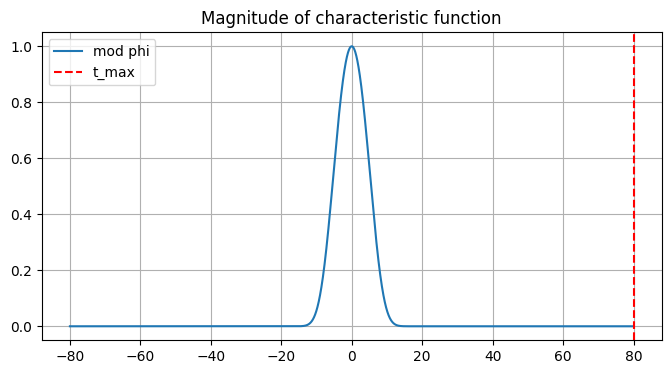

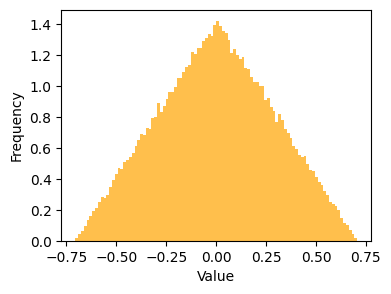

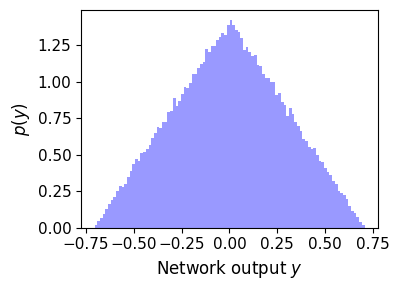

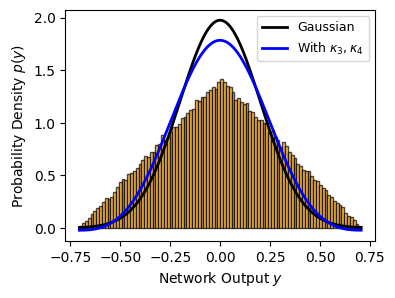

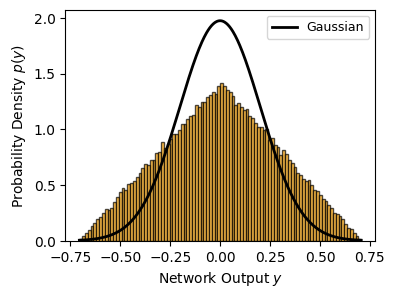

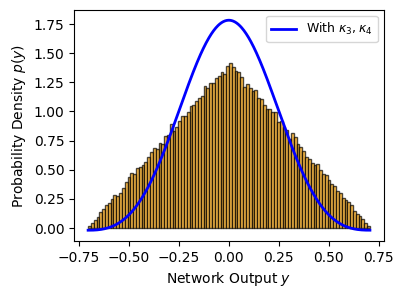

{'kappa1': np.float32(0.0004920076), 'kappa2': np.float32(0.08292511), 'kappa3': np.float32(-9.4971234e-05), 'kappa4': np.float32(-0.0041252803)}
{'kappa1': np.float32(0.00049200765), 'kappa2': np.float32(0.082925096), 'kappa3': np.float32(-9.497129e-05), 'kappa4': np.float32(-0.004125271)}

Extracted Cumulants (of raw network output):
kappa1: 0.000695791793987155
kappa2: 0.08310996741056442
kappa3: 0.00012775864161085337
kappa4: -0.0020499397069215775


DEBUG: Trace of Layer 1 covariance (B): 0.10150896619307524


------------
Propagation complete. Propagated cumulants:
 mean: 0.000351715548151978 
 cov: 0.04070562535667679

 g3: -3.265193012681906e-05 
 g4: -0.000993591620964597

Layer 1 ||W_self||²: 0.1690417846216974
Layer 1 ||W_neigh||²: 1.0550623187084796
Layer 2 ||W_self||²: 0.4961943688785669
Layer 2 ||W_neigh||²: 0.5043893709125604


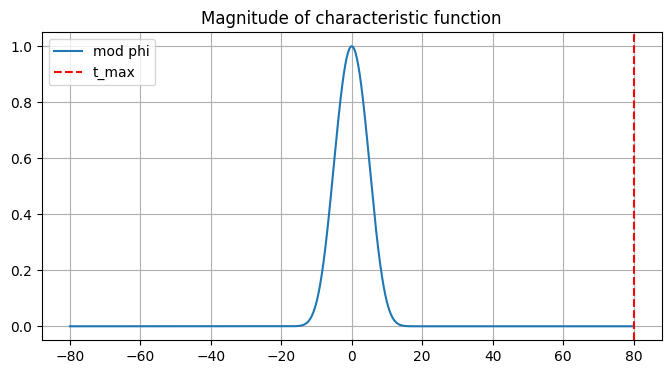

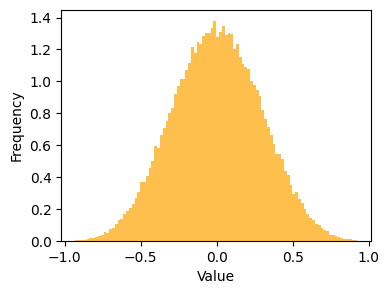

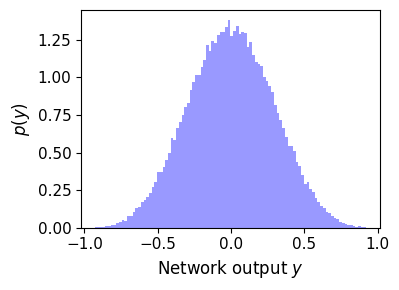

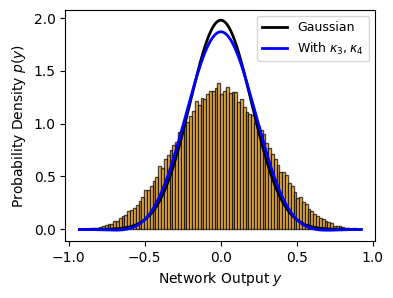

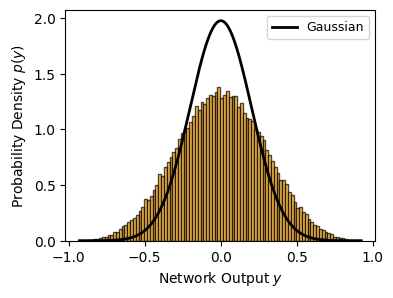

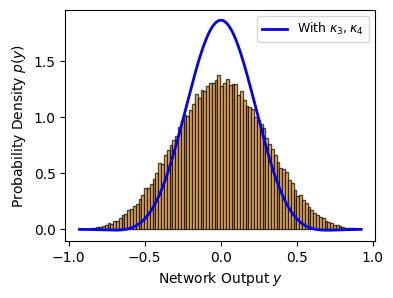

{'kappa1': np.float32(0.0006957918), 'kappa2': np.float32(0.08310997), 'kappa3': np.float32(0.00012775864), 'kappa4': np.float32(-0.0020499397)}
{'kappa1': np.float32(0.0006957918), 'kappa2': np.float32(0.08310997), 'kappa3': np.float32(0.00012775867), 'kappa4': np.float32(-0.0020499378)}

Extracted Cumulants (of raw network output):
kappa1: 0.0009839810663834214
kappa2: 0.0829474925994873
kappa3: 0.00022435815481003374
kappa4: -0.001124449074268341


DEBUG: Trace of Layer 1 covariance (B): 0.1017352521349092


------------
Propagation complete. Propagated cumulants:
 mean: 0.0004973923123541922 
 cov: 0.0407963661891846

 g3: 4.392452395067048e-05 
 g4: -0.0004937368530919713

Layer 1 ||W_self||²: 0.1690417846216974
Layer 1 ||W_neigh||²: 1.0550623187084796
Layer 2 ||W_self||²: 0.4961943688785669
Layer 2 ||W_neigh||²: 0.5043893709125604


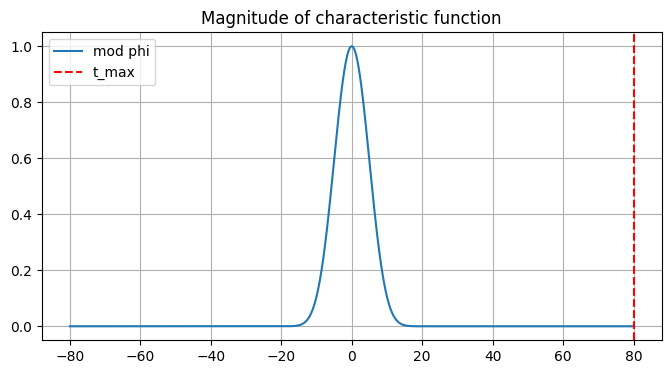

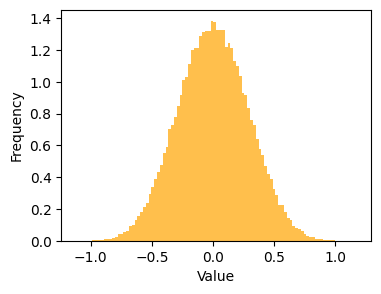

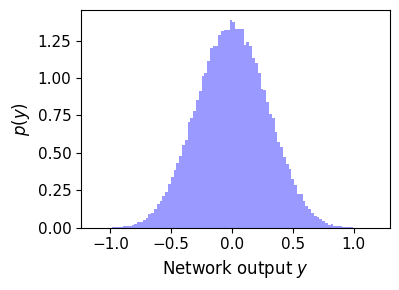

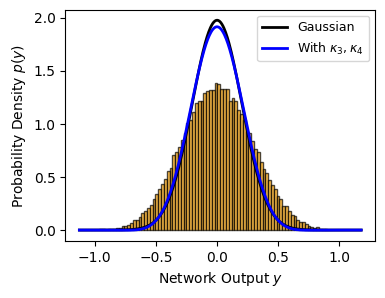

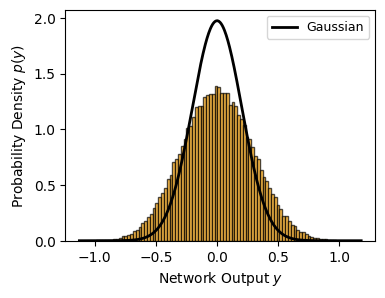

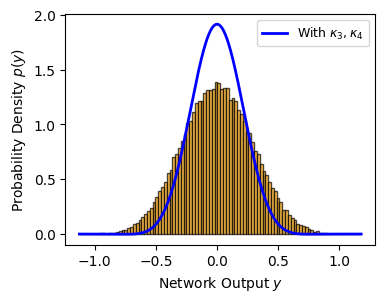

{'kappa1': np.float32(0.0009839811), 'kappa2': np.float32(0.08294749), 'kappa3': np.float32(0.00022435815), 'kappa4': np.float32(-0.0011244491)}
{'kappa1': np.float32(0.0009839808), 'kappa2': np.float32(0.0829475), 'kappa3': np.float32(0.00022435815), 'kappa4': np.float32(-0.0011244528)}

Extracted Cumulants (of raw network output):
kappa1: 0.001391535042785108
kappa2: 0.08310220390558243
kappa3: 0.00018790662579704076
kappa4: -0.0005794297903776169


DEBUG: Trace of Layer 1 covariance (B): 0.10153636731144133


------------
Propagation complete. Propagated cumulants:
 mean: 0.0007034067100246948 
 cov: 0.040716611834095265

 g3: 7.71362705506519e-05 
 g4: -0.00027082842754687163

Layer 1 ||W_self||²: 0.1690417846216974
Layer 1 ||W_neigh||²: 1.0550623187084796
Layer 2 ||W_self||²: 0.4961943688785669
Layer 2 ||W_neigh||²: 0.5043893709125604


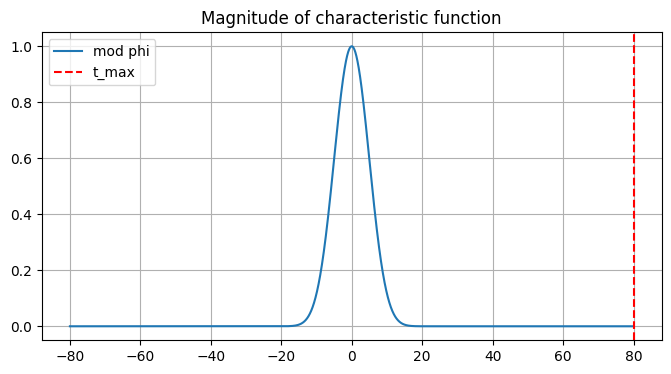

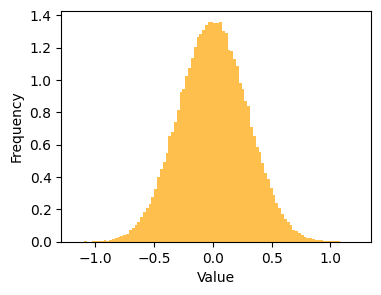

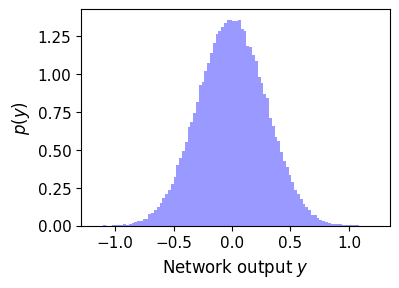

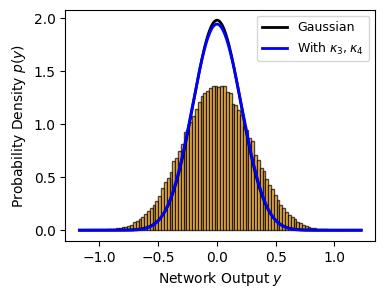

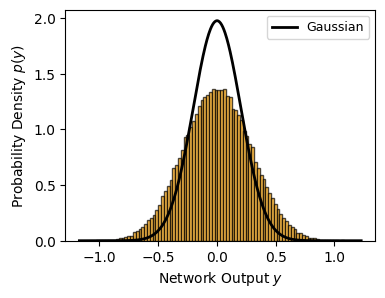

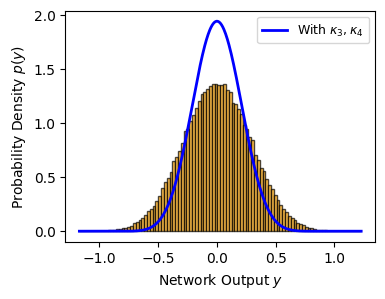

{'kappa1': np.float32(0.001391535), 'kappa2': np.float32(0.083102204), 'kappa3': np.float32(0.00018790663), 'kappa4': np.float32(-0.0005794298)}
{'kappa1': np.float32(0.0013915352), 'kappa2': np.float32(0.083102204), 'kappa3': np.float32(0.00018790668), 'kappa4': np.float32(-0.0005794298)}

Extracted Cumulants (of raw network output):
kappa1: 0.001967893447726965
kappa2: 0.08273982256650925
kappa3: 0.0004521759401541203
kappa4: -0.00016069039702415466


DEBUG: Trace of Layer 1 covariance (B): 0.1017257487966045


------------
Propagation complete. Propagated cumulants:
 mean: 0.000994749922691395 
 cov: 0.04079255530100807

 g3: 6.460392018297356e-05 
 g4: -0.00013955817350277486

Layer 1 ||W_self||²: 0.1690417846216974
Layer 1 ||W_neigh||²: 1.0550623187084796
Layer 2 ||W_self||²: 0.4961943688785669
Layer 2 ||W_neigh||²: 0.5043893709125604


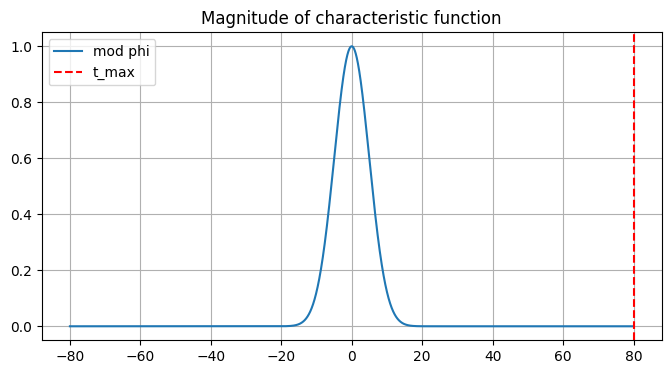

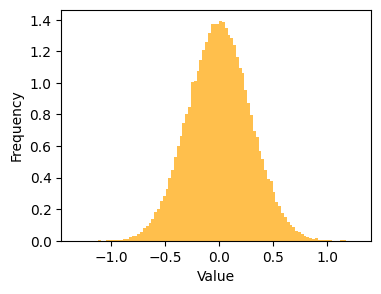

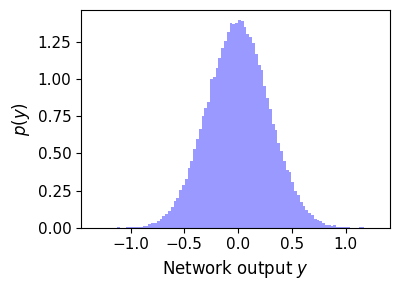

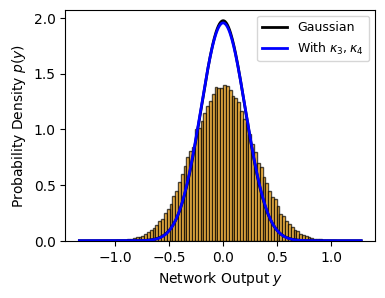

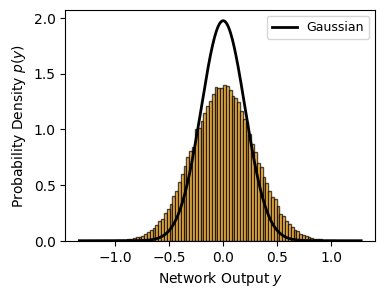

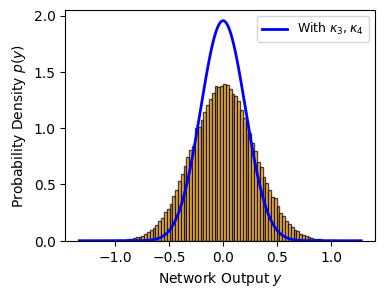

{'kappa1': np.float32(0.0019678934), 'kappa2': np.float32(0.08273982), 'kappa3': np.float32(0.00045217594), 'kappa4': np.float32(-0.0001606904)}
{'kappa1': np.float32(0.0019678934), 'kappa2': np.float32(0.08273982), 'kappa3': np.float32(0.0004521759), 'kappa4': np.float32(-0.0001606904)}

Extracted Cumulants (of raw network output):
kappa1: 0.002782973228022456
kappa2: 0.0828973725438118
kappa3: 0.00028173139435239136
kappa4: -7.468834519386292e-05


DEBUG: Trace of Layer 1 covariance (B): 0.10128215631247474


------------
Propagation complete. Propagated cumulants:
 mean: 0.0014067643235954129 
 cov: 0.04061467240357022

 g3: 0.00015546199194655145 
 g4: -3.8702977790478925e-05

Layer 1 ||W_self||²: 0.1690417846216974
Layer 1 ||W_neigh||²: 1.0550623187084796
Layer 2 ||W_self||²: 0.4961943688785669
Layer 2 ||W_neigh||²: 0.5043893709125604


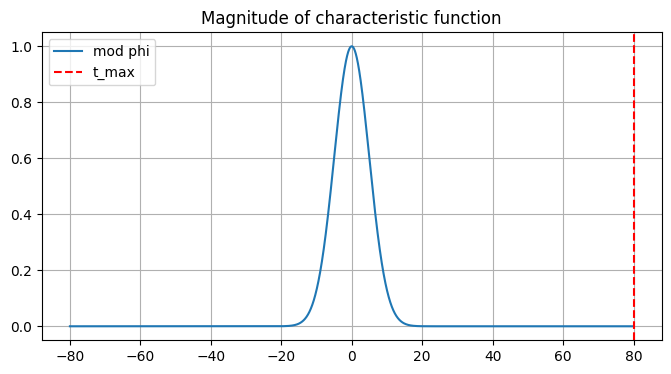

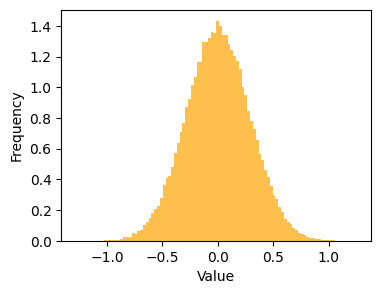

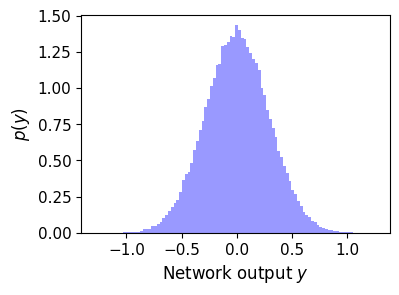

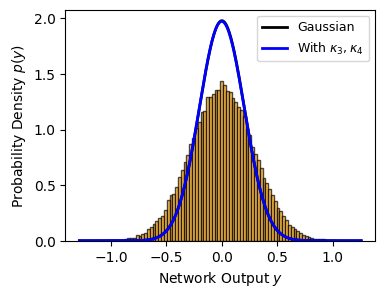

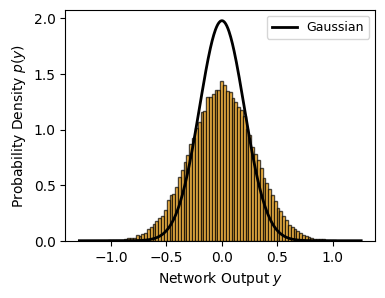

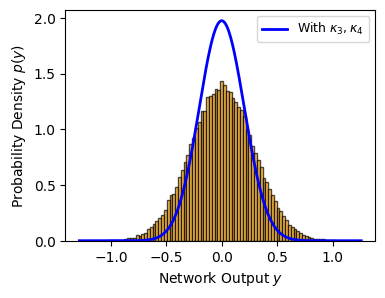

{'kappa1': np.float32(0.0027829732), 'kappa2': np.float32(0.08289737), 'kappa3': np.float32(0.0002817314), 'kappa4': np.float32(-7.4688345e-05)}
{'kappa1': np.float32(0.0027829728), 'kappa2': np.float32(0.08289737), 'kappa3': np.float32(0.0002817314), 'kappa4': np.float32(-7.4688345e-05)}

Extracted Cumulants (of raw network output):
kappa1: 0.003935649991035461
kappa2: 0.0827770084142685
kappa3: 3.939981615985744e-05
kappa4: 3.76235693693161e-05


DEBUG: Trace of Layer 1 covariance (B): 0.10147501388617038


------------
Propagation complete. Propagated cumulants:
 mean: 0.0019894306006006685 
 cov: 0.04069200929549054

 g3: 9.68616856194905e-05 
 g4: -1.7989011283674783e-05

Layer 1 ||W_self||²: 0.1690417846216974
Layer 1 ||W_neigh||²: 1.0550623187084796
Layer 2 ||W_self||²: 0.4961943688785669
Layer 2 ||W_neigh||²: 0.5043893709125604


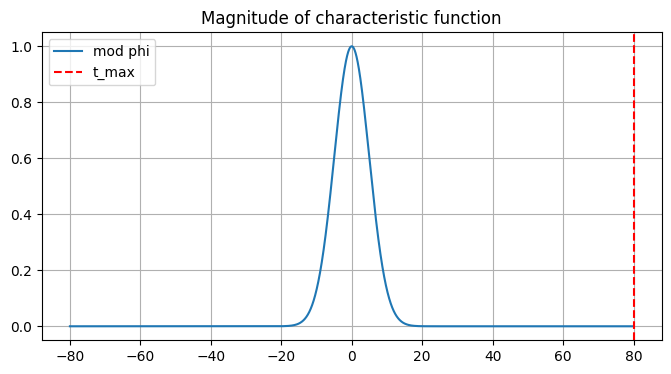

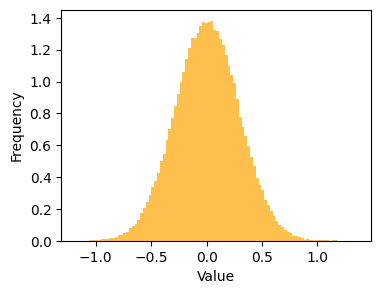

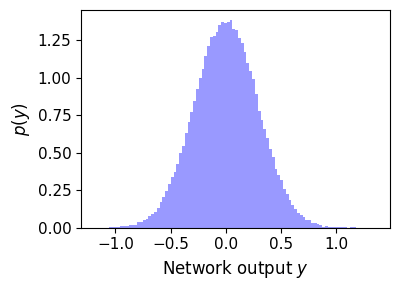

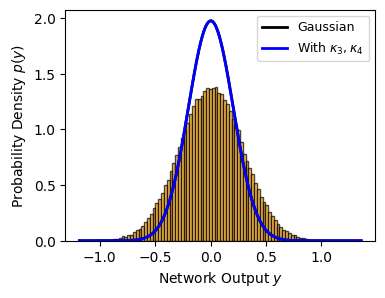

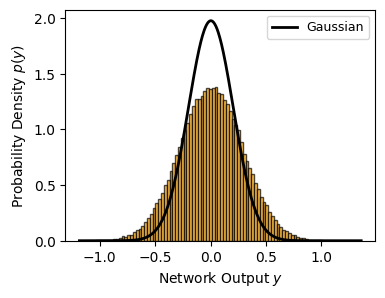

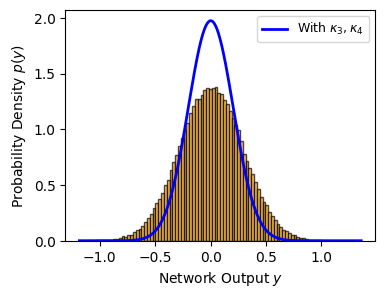

{'kappa1': np.float32(0.00393565), 'kappa2': np.float32(0.08277701), 'kappa3': np.float32(3.9399816e-05), 'kappa4': np.float32(3.762357e-05)}
{'kappa1': np.float32(0.0039356505), 'kappa2': np.float32(0.08277701), 'kappa3': np.float32(3.9397517e-05), 'kappa4': np.float32(3.762357e-05)}

Extracted Cumulants (of raw network output):
kappa1: 0.00556575320661068
kappa2: 0.08318132907152176
kappa3: 9.844644227996469e-05
kappa4: 9.990297257900238e-05


DEBUG: Trace of Layer 1 covariance (B): 0.10132767566130266


------------
Propagation complete. Propagated cumulants:
 mean: 0.0028134307835700643 
 cov: 0.040632925899625

 g3: 1.3545996940867758e-05 
 g4: 9.061799564041771e-06

Layer 1 ||W_self||²: 0.1690417846216974
Layer 1 ||W_neigh||²: 1.0550623187084796
Layer 2 ||W_self||²: 0.4961943688785669
Layer 2 ||W_neigh||²: 0.5043893709125604


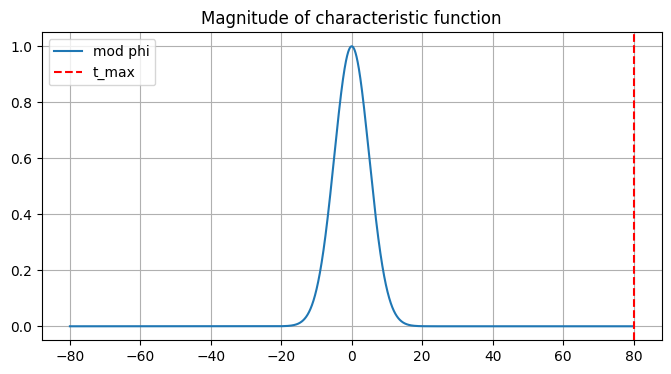

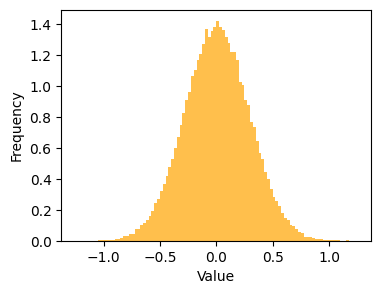

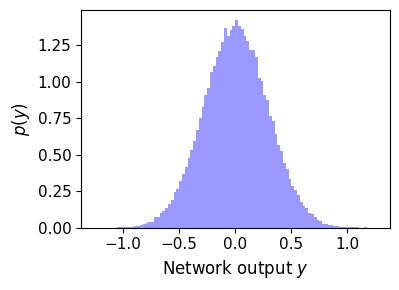

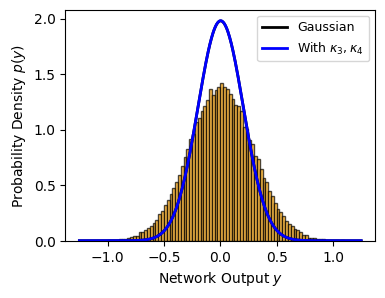

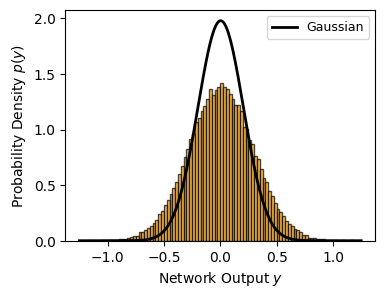

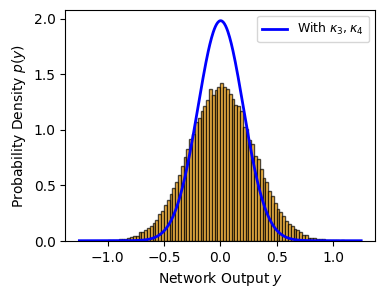

{'kappa1': np.float32(0.005565753), 'kappa2': np.float32(0.08318133), 'kappa3': np.float32(9.844644e-05), 'kappa4': np.float32(9.990297e-05)}
{'kappa1': np.float32(0.0055657537), 'kappa2': np.float32(0.08318133), 'kappa3': np.float32(9.844644e-05), 'kappa4': np.float32(9.990297e-05)}

Extracted Cumulants (of raw network output):
kappa1: 0.007871028035879135
kappa2: 0.08320135623216629
kappa3: 0.0002928237081505358
kappa4: -2.8308480978012085e-05


DEBUG: Trace of Layer 1 covariance (B): 0.10182260623690752


------------
Propagation complete. Propagated cumulants:
 mean: 0.003978723066085731 
 cov: 0.040831395639237225

 g3: 3.3846736762861285e-05 
 g4: 2.4062063449546033e-05

Layer 1 ||W_self||²: 0.1690417846216974
Layer 1 ||W_neigh||²: 1.0550623187084796
Layer 2 ||W_self||²: 0.4961943688785669
Layer 2 ||W_neigh||²: 0.5043893709125604


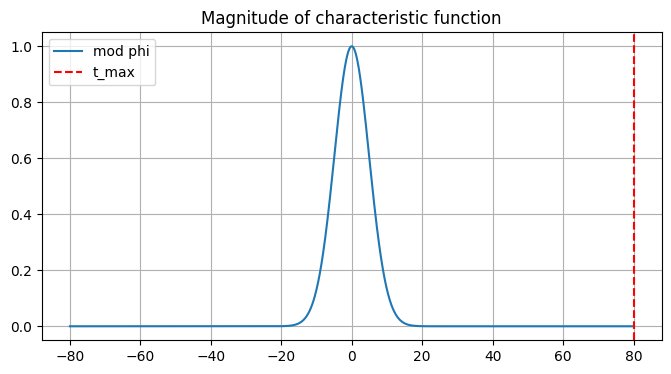

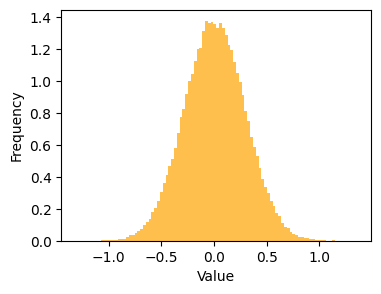

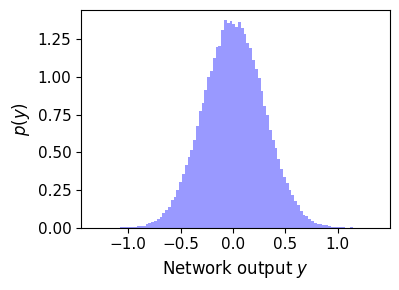

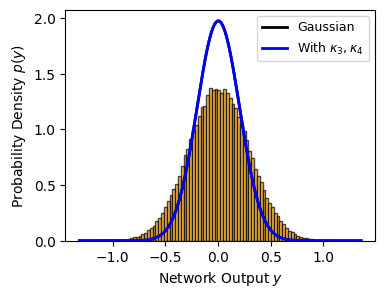

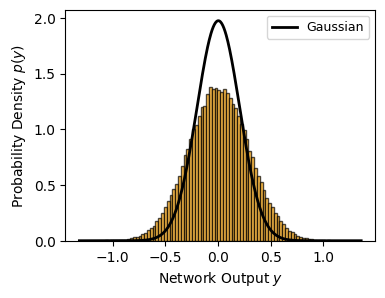

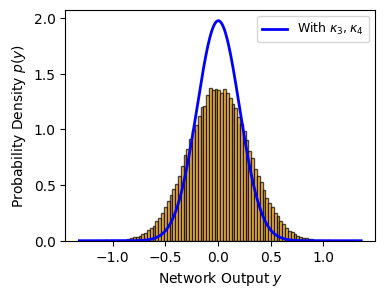

{'kappa1': np.float32(0.007871028), 'kappa2': np.float32(0.083201356), 'kappa3': np.float32(0.0002928237), 'kappa4': np.float32(-2.8308481e-05)}
{'kappa1': np.float32(0.007871027), 'kappa2': np.float32(0.083201356), 'kappa3': np.float32(0.0002928237), 'kappa4': np.float32(-2.8308481e-05)}

Extracted Cumulants (of raw network output):
kappa1: 0.011131121776998043
kappa2: 0.08327165991067886
kappa3: 0.00040062444168142974
kappa4: 6.313435733318329e-05


DEBUG: Trace of Layer 1 covariance (B): 0.10184712156643055


------------
Propagation complete. Propagated cumulants:
 mean: 0.005626667149858392 
 cov: 0.04084122641411106

 g3: 0.00010067531886536407 
 g4: -6.818220197747754e-06

Layer 1 ||W_self||²: 0.1690417846216974
Layer 1 ||W_neigh||²: 1.0550623187084796
Layer 2 ||W_self||²: 0.4961943688785669
Layer 2 ||W_neigh||²: 0.5043893709125604


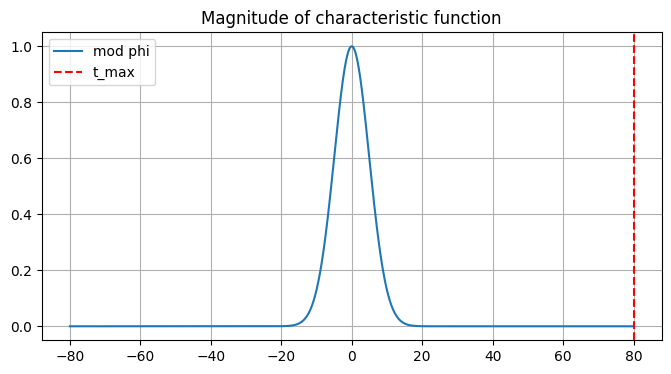

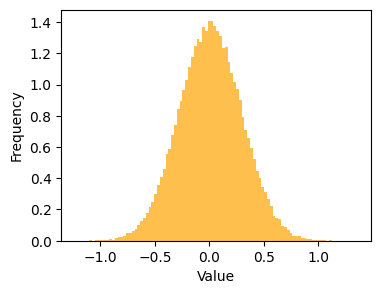

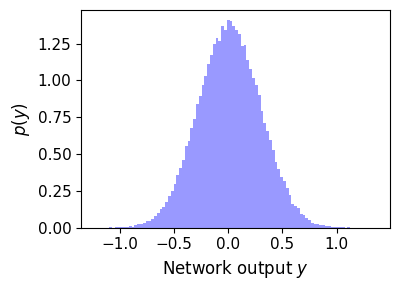

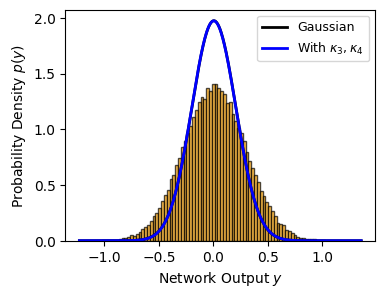

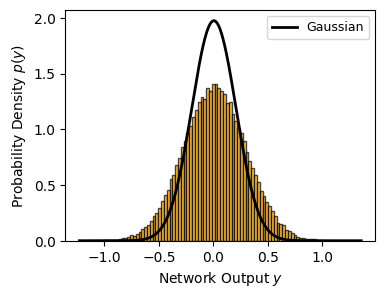

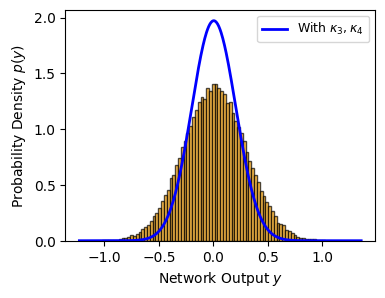

In [40]:
# First extract weights and biases from the model
weights = extract_weights(model)

# W1_self = weights[0]['W_self']
# W1_neigh = weights[0]['W_neigh']

print(f"{len(weights)}")
print(f"weights: {weights}")




# Uniform test set
x_test_uni, y_test_uni = get_data_uniform(n_test)
uniform_samples = GraphPairDataset(x_test_uni, y_test_uni)
uniform_loader = DataLoader(uniform_samples, batch_size=64, shuffle=False)



# input_samples, input_loader = test_dataset, test_loader
# JL_test_samples = test_dataset
input_samples, input_loader = uniform_samples, uniform_loader
data_in, data_out = x_test_uni, y_test_uni
JL_test_samples = uniform_samples
num_iterations = 10

# As a check compare the expected JL evolution of cumulants after num_iterations
_, _, avg_initial_cumulants = find_input_cumulants(data_in)
predicted_cumulants = JL_cumulant_evolution(avg_initial_cumulants, num_iterations)
print("\n~~~Here's a check that I've done it right!~~~~:\nPredicted Cumulants (after all iterations):")
for k, v in predicted_cumulants.items():
    print(f"{k}: {v}")

for number in range(num_iterations):
    
    # region

    #############
    # Find and save the JL prediction cumulants after this num_iterations
    #############
    JL_number = number + 1
    JL_expected_c = JL_cumulant_evolution(avg_initial_cumulants, JL_number)

    # endregion

    # region
    #############
    # Cumulant extraction, get next dataset
    #############

    # print(f"\nExpected cumulants for uniform distribution: \n {1/2}, {1/12}, {0}, {-1/120}")  # Expected cumulants for uniform distribution
    col1, col2, avg_input_c = find_input_cumulants(data_in)
    input_mean_list = [col1['kappa1'], col2['kappa1']] # treat col1 ~ node A, col2 ~ node B
    input_cov_list = [col1['kappa2'], col2['kappa2']]
    input_g3_list = [col1['kappa3'], col2['kappa3']]
    input_g4_list = [col1['kappa4'], col2['kappa4']]
    print(col1)
    print(col2)

    avg_jl_cumulants, ground_truth_c = find_pred_output_cumulants(data_in, data_out)
    network_outputs, network_cumulants = find_network_output_cumulants(input_loader, model)

    # Redefine dataset for next iteration
    data_in, data_out, input_loader = shuffle(network_outputs)



    # Propagate cumulants

    # Networks without nonlinearity
    mu_out, cov_out, g3_out, g4_out = propagate_full_linear(input_mean_list, input_cov_list, input_g3_list, 
                                                            input_g4_list, weights)
    # mu_out, cov_out, g3_out, g4_out = layer1_prop_1D(input_mean_list, input_cov_list, input_g3_list, 
    #                                                         input_g4_list, W1_self, W1_neigh)
    cumulants_plotting = [mu_out, cov_out, g3_out, g4_out]

    print("\n\n------------\nPropagation complete. Propagated cumulants:")
    print(f" mean: {mu_out} \n cov: {cov_out}\n")
    print(f" g3: {g3_out} \n g4: {g4_out}\n") # include if using higher cumulants

    for i, layer in enumerate(weights):
        print(f"Layer {i+1} ||W_self||²:", torch.norm(layer["W_self"]).item()**2)
        print(f"Layer {i+1} ||W_neigh||²:", torch.norm(layer["W_neigh"]).item()**2)


    # endregion

    # region
    ###############
    # Plot this iteration
    ###############

    y_vals = np.linspace(np.min(network_outputs), np.max(network_outputs), 500)

    # Find the pdf using propagated cumulants
    pdf_truncated_propagated = theoretical_pdf_normal(y_vals, mu_out, cov_out)
    pdf_higher_propagated = pdf_from_cumulants(y_vals, cumulants_plotting, t_max=80, num_points=2**13, plot=True)

    plot_histogram(network_outputs, bins=100, color='orange', show=True, norm=True, edgecolor='none')

    plot_histogram_thesis(network_outputs, bins=100, show=True, alpha=0.4)

    # Plot with both overlaid
    plot_histogram(network_outputs, bins=100, color='orange', show=False, norm=True)
    plt.plot(y_vals, pdf_truncated_propagated, label="Gaussian", color='black', linewidth=2)
    plt.plot(y_vals, pdf_higher_propagated, label="With $\kappa_{3}, \kappa_{4}$", color='blue', linewidth=2)

    # plt.title("Empirical Data vs Theoretical PDF")
    plt.xlabel("Network Output $y$")
    plt.ylabel("Probability Density $p(y)$")
    plt.legend(fontsize=9)
    plt.show()


    # Plot with just truncated
    plot_histogram(network_outputs, bins=100, color='orange', show=False, norm=True)
    plt.plot(y_vals, pdf_truncated_propagated, label="Gaussian", color='black', linewidth=2)
    plt.xlabel("Network Output $y$")
    plt.ylabel("Probability Density $p(y)$")
    plt.legend(fontsize=9)
    plt.show()

    # Plot with just higher
    plot_histogram(network_outputs, bins=100, color='orange', show=False, norm=True)
    plt.plot(y_vals, pdf_higher_propagated, label="With $\kappa_{3}, \kappa_{4}$", color='blue', linewidth=2)
    # plt.axvline(x=cumulants_plotting[0], color='red', linestyle='--', label='Mean')
    plt.xlabel("Network Output $y$")
    plt.ylabel("Probability Density $p(y)$")
    plt.legend(fontsize=9)
    plt.show()


    # endregion

    # region
    ##################
    # Consistency with analytical results
    ##################

    # layer1, layer2 = weights[0], weights[1]
    # w0, w1, w2, w3 = layer1[0, 0], layer1[0, 1], layer1[1, 0], layer1[1, 1]
    # a0, a1 = layer2[0, 0], layer2[0, 1]

    # if biases:
    #     biases1, biases2 = biases[0], biases[1]
    #     b0, b1 = biases1[0], biases1[1]
    #     b2 = biases2[0]

    # w0_save = w0.item()
    # s2_2a0_w1 = np.sqrt(2)/(2 * a0) - w1
    # s2_2a0_w1 = s2_2a0_w1.item()

    # print(f"w0: {w0_save}, sqrt(2)/2a0 - w1: {s2_2a0_w1}")
    # if biases:
    #     print(f"b2: {b2}, -2*a0*b1: {-2 * a0 * b1}")

    # endregion

    # region
    ###################
    # KL divergence
    ###################

    # Ground truth
    gt_cumulants_list_linear = [ground_truth_c['kappa1'], ground_truth_c['kappa2'], ground_truth_c['kappa3'], ground_truth_c['kappa4']]
    gt_pdf_trunc = theoretical_pdf_normal(y_vals, ground_truth_c['kappa1'], ground_truth_c['kappa2'])
    gt_pdf_higher = pdf_from_cumulants(y_vals, gt_cumulants_list_linear, t_max=80, num_points=2**13)

    # JL predictions
    jl_cumulants_list_linear = [avg_jl_cumulants['kappa1'], avg_jl_cumulants['kappa2'], avg_jl_cumulants['kappa3'], avg_jl_cumulants['kappa4']]
    jl_pdf_trunc = theoretical_pdf_normal(y_vals, avg_jl_cumulants['kappa1'], avg_jl_cumulants['kappa2'])
    jl_pdf_higher = pdf_from_cumulants(y_vals, jl_cumulants_list_linear, t_max=80, num_points=2**13)


    # Find KL divergences

    # network output/ground truth
    kl_netout_gt_trunc = norm_kl_div_histtopdf(network_outputs, gt_pdf_trunc, y_vals)
    kl_netout_gt_higher = norm_kl_div_histtopdf(network_outputs, gt_pdf_higher, y_vals)

    # propagated/ground truth
    kl_propagated_gt_trunc = norm_kl_div_pdf2pdf(pdf_truncated_propagated, gt_pdf_trunc, y_vals)
    kl_propagated_gt_higher = norm_kl_div_pdf2pdf(pdf_higher_propagated, gt_pdf_higher, y_vals)

    # network output/propagated
    kl_netout_propagated_trunc = norm_kl_div_histtopdf(network_outputs, pdf_truncated_propagated, y_vals)
    kl_netout_propagated_higher = norm_kl_div_histtopdf(network_outputs, pdf_higher_propagated, y_vals)

    # JL predictions/ground truth
    kl_jl_gt_trunc = norm_kl_div_pdf2pdf(jl_pdf_trunc, gt_pdf_trunc, y_vals)
    kl_jl_gt_higher = norm_kl_div_pdf2pdf(jl_pdf_higher, gt_pdf_higher, y_vals)

    # network output/JL predictions
    kl_netout_jl_trunc = norm_kl_div_histtopdf(network_outputs, jl_pdf_trunc, y_vals)
    kl_netout_jl_higher = norm_kl_div_histtopdf(network_outputs, jl_pdf_higher, y_vals)


    # endregion

    # region
    ##################
    # Wasserstein distance
    ##################

    # Find the distances

    # network output/ground truth
    wd_netout_gt_trunc = norm_kl_div_histtopdf(network_outputs, gt_pdf_trunc, y_vals)
    wd_netout_gt_higher = norm_kl_div_histtopdf(network_outputs, gt_pdf_higher, y_vals)

    # propagated/ground truth
    wd_propagated_gt_trunc = norm_kl_div_pdf2pdf(pdf_truncated_propagated, gt_pdf_trunc, y_vals)
    wd_propagated_gt_higher = norm_kl_div_pdf2pdf(pdf_higher_propagated, gt_pdf_higher, y_vals)

    # network output/propagated
    wd_netout_propagated_trunc = norm_kl_div_histtopdf(network_outputs, pdf_truncated_propagated, y_vals)
    wd_netout_propagated_higher = norm_kl_div_histtopdf(network_outputs, pdf_higher_propagated, y_vals)

    # JL predictions/ground truth
    wd_jl_gt_trunc = norm_kl_div_pdf2pdf(jl_pdf_trunc, gt_pdf_trunc, y_vals)
    wd_jl_gt_higher = norm_kl_div_pdf2pdf(jl_pdf_higher, gt_pdf_higher, y_vals)

    # network output/JL predictions
    wd_netout_jl_trunc = norm_kl_div_histtopdf(network_outputs, jl_pdf_trunc, y_vals)
    wd_netout_jl_higher = norm_kl_div_histtopdf(network_outputs, jl_pdf_higher, y_vals)




    # endregion

    # region
    ####################
    # Save to excel file
    #####################

    def find_next_empty_row(ws, anchor_col=2):
        row = 6
        while ws.cell(row=row, column=anchor_col).value is not None:
            row += 1
        return row

    # Load your workbook and sheet
    wb = load_workbook(r"C:\Users\cga28\Documents\Project\GNN_data.xlsx")
    ws = wb["sage conv"]  # or the exact name of your sheet

    # Example: write raw cumulants starting at column H (8), row 3
    start_row = find_next_empty_row(ws)
    start_col = 2 #(B)
    cumulant_start_column = 7
    KL_start_column = 27
    wass_start_column = 38
    JL_start_column = 49
    real_number = number + 1

    ws.cell(row=start_row, column=start_col, value=real_number)
    ws.cell(row=start_row, column=start_col - 1, value=SEED)


    # # Write average input cumulants (1st row)
    # for i, val in enumerate(avg_input_c.values()):
    #     ws.cell(row=start_row, column=cumulant_start_column + i, value=float(val))

    # # Write JL prediction cumulants
    # for i, val in enumerate(avg_jl_cumulants.values()):
    #     ws.cell(row=start_row, column=cumulant_start_column + 4 + i, value=float(val))

    # Write empirical cumulants
    for i, val in enumerate(network_cumulants.values()):
        ws.cell(row=start_row, column=cumulant_start_column + 8 + i, value=float(val))

    # Write propagated cumulants
    for i, val in enumerate(cumulants_plotting):
        ws.cell(row=start_row, column=cumulant_start_column + 12 + i, value=float(val))

    # Write ground truth cumulants
    for i, val in enumerate(ground_truth_c.values()):
        ws.cell(row=start_row, column=cumulant_start_column + 16 + i, value=float(val))


    ws.cell(row=start_row, column=KL_start_column, value=kl_netout_gt_trunc)
    ws.cell(row=start_row, column=KL_start_column+1, value=kl_netout_gt_higher)

    ws.cell(row=start_row, column=KL_start_column+2, value=kl_propagated_gt_trunc)
    ws.cell(row=start_row, column=KL_start_column+3, value=kl_propagated_gt_higher)

    ws.cell(row=start_row, column=KL_start_column+4, value=kl_netout_propagated_trunc)
    ws.cell(row=start_row, column=KL_start_column+5, value=kl_netout_propagated_higher)

    ws.cell(row=start_row, column=KL_start_column+6, value=kl_jl_gt_trunc)
    ws.cell(row=start_row, column=KL_start_column+7, value=kl_jl_gt_higher)

    ws.cell(row=start_row, column=KL_start_column+8, value=kl_netout_jl_trunc)
    ws.cell(row=start_row, column=KL_start_column+9, value=kl_netout_jl_higher)



    # # Write wasserstein distances
    # ws.cell(row=start_row, column=wass_start_column, value=wd_netout_gt_trunc)
    # ws.cell(row=start_row, column=wass_start_column+1, value=wd_netout_gt_higher)

    # ws.cell(row=start_row, column=wass_start_column+2, value=wd_propagated_gt_trunc)
    # ws.cell(row=start_row, column=wass_start_column+3, value=wd_propagated_gt_higher)

    # ws.cell(row=start_row, column=wass_start_column+4, value=wd_netout_propagated_trunc)
    # ws.cell(row=start_row, column=wass_start_column+5, value=wd_netout_propagated_higher)

    # ws.cell(row=start_row, column=wass_start_column+6, value=wd_jl_gt_trunc)
    # ws.cell(row=start_row, column=wass_start_column+7, value=wd_jl_gt_higher)

    # ws.cell(row=start_row, column=wass_start_column+8, value=wd_netout_jl_trunc)
    # ws.cell(row=start_row, column=wass_start_column+9, value=wd_netout_jl_higher)


    # Save the JL expected values (from the inputs alone) after number iterations
    for i, val in enumerate(JL_expected_c.values()):
        ws.cell(row=start_row, column=JL_start_column + i, value=float(val))

    # Save workbook
    wb.save(r"C:\Users\cga28\Documents\Project\GNN_data.xlsx")
    # endregion